# Libraries and Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [242]:
region = pd.read_csv('../data/ny_zip.csv',dtype={'zip':'object'})
ny_zip = region['zip'].copy()
zri = pd.read_csv('../data/ny_zri.csv',dtype={'zip':'object'}).set_index('zip')
# zri = zri.iloc[:,:-3].set_index('zip')

In [912]:
adp = pd.read_csv('../data/ny_zri_adp.csv',dtype={'zip':'object'}).set_index(['time','zip'])

Select top 5 importance features for NYC.

In [913]:
# adp = adp[['ann_gross_pay_proj_mle_gen_x_m','ann_gross_pay_proj_mle_gen_y_m','ann_gross_pay_proj_gen_x_m',
#             'rate_amt_s_90perc_value','ann_bonus_m']]

# Train Test Split

In [307]:
adp_train = adp.loc[(slice('2018-12'),slice(None)),:]
adp_test = adp.loc[(slice('2019-01','2019-09'),slice(None)),:]

In [244]:
zri_train = zri.iloc[:,:-12]
zri_test = zri.iloc[:,-12:]

In [103]:
# adp_train.loc[(slice(None),ny_zip[0]),:].unstack()

# Benchmark Model

Set up lists to store results.
- stat: coefficients. 
- predict: predictions.
- conf_upper & conf_lower: confidence intervals.

In [249]:
stat_bm = pd.DataFrame(np.zeros(shape=(zri_train.shape[0],4)),
                    index=zri_train.index,columns=['ar','p(ar)','s','p(s)'])
n_month = 12
predict_bm = pd.DataFrame(np.zeros(shape=(zri_train.shape[0],n_month)),
                       index=zri_train.index,columns=[str(i) for i in range(1,n_month+1)])
conf_lower_bm = predict_bm.copy()
conf_upper_bm = predict_bm.copy()

In [250]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [251]:
# About 1 minutes
nzip = zri_train.shape[0]
for i in range(nzip):
    one = zri_train.iloc[i,:]
    mod = sm.tsa.statespace.SARIMAX(one, order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
    res = mod.fit(disp=False)
    
    stat_bm.iloc[i,:] = [res.arparams[0],res.pvalues[0],res.seasonalarparams[0],res.pvalues[1]]
    predict_bm.iloc[i,:] = res.predict('2019-01','2019-12').to_list()
    
    pred = res.get_prediction(start='2019-01',end='2019-12')
    conf = pred.conf_int()# 95% conf
    conf_lower_bm.iloc[i,:] = conf.iloc[:, 0].to_list()
    conf_upper_bm.iloc[i,:] = conf.iloc[:, 1].to_list()

In [252]:
def plot_forcast(zipcode,predict,conf_lower,conf_upper):
    plt.figure(figsize=(6,4), dpi=100)
    train_one, test_one = zri_train.loc[zipcode].copy(), zri_test.loc[zipcode].copy()
    train_one.index, test_one.index = pd.to_datetime(train_one.index), pd.to_datetime(test_one.index)
    plt.plot(train_one, label='training')
    plt.plot(test_one, label='actual')
    plt.plot(test_one.index,predict.loc[zipcode], label='forecast')
    plt.fill_between(test_one.index, conf_lower.loc[zipcode], conf_upper.loc[zipcode], 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

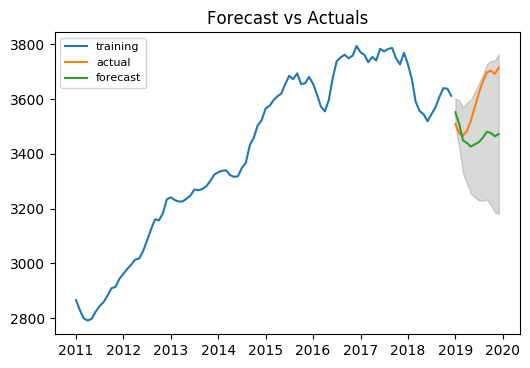

In [456]:
plot_forcast('10025',predict_bm,conf_lower_bm,conf_upper_bm)

In [264]:
predict_bm.columns = zri_test.columns

toy_model = pd.concat([zri_train.iloc[:,-1]]*12,axis=1)
toy_model.columns = zri_test.columns

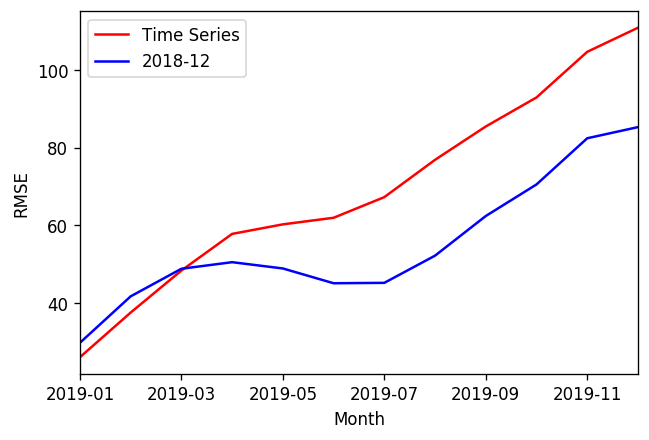

In [1245]:
rmse_bm = (np.sum((predict_bm - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_bm.plot(c='r',label = 'Time Series')

rmse_toy = (np.sum((toy_model - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_toy.plot(c='b',label = '2018-12')

plt.xlabel('Month')
plt.ylabel('RMSE')
plt.legend()

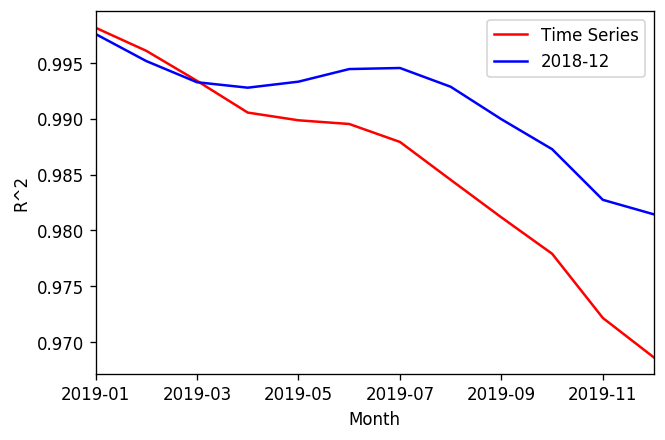

In [1247]:
R2_bm = 1-np.sum((zri_test-predict_bm)**2)/np.sum((zri_test-zri_test.mean())**2)
R2_bm.plot(c='r',label = 'Time Series')

R2_toy = 1-np.sum((zri_test-toy_model)**2)/np.sum((zri_test-zri_test.mean())**2)
R2_toy.plot(c='b',label = '2018-12')

plt.xlabel('Month')
plt.ylabel('R^2')
plt.legend()

# Add ADP Most Important Features

In [267]:
stat_adp = pd.DataFrame(np.zeros(shape=(zri_train.shape[0],4)),
                    index=zri_train.index,columns=['ar','p(ar)','s','p(s)'])
n_month = 12
predict_adp = pd.DataFrame(np.zeros(shape=(zri_train.shape[0],n_month)),
                       index=zri_train.index,columns=[str(i) for i in range(1,n_month+1)])
conf_lower_adp = predict_adp.copy()
conf_upper_adp = predict_adp.copy()

## Use SARIMAX to Forcast One Zip Code

In [314]:
one = zri_train.iloc[0,:]
vip1 = adp_train[adp_train.index.map(lambda idx: idx[1] ==  one.name)]['ann_gross_pay_proj_mle_gen_x_m'].unstack()

In [315]:
mod = sm.tsa.statespace.SARIMAX(one, exog=vip1, order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
res = mod.fit(disp=False)
# print(res.summary())

In [316]:
vip1_test = adp_test[adp_test.index.map(lambda idx: idx[1] ==  one.name)]['ann_gross_pay_proj_mle_gen_x_m']
vip1_test = vip1_test.reset_index().set_index('time')['ann_gross_pay_proj_mle_gen_x_m']
res.predict('2019-01','2019-09',exog = vip1_test)

2019-01-01    3543.727567
2019-02-01    3494.340309
2019-03-01    3436.897247
2019-04-01    3426.329105
2019-05-01    3413.600726
2019-06-01    3423.035658
2019-07-01    3439.899286
2019-08-01    3460.705801
2019-09-01    3478.950380
Freq: MS, dtype: float64

You need exog from 2019-01 to 2019-09 to predict ZRI at this time. It's not what we want.

## Use VARMAX to Forcast One Zip Code

In [327]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

In [349]:
one = zri_train.iloc[0,:]

selected = ['ann_gross_pay_proj_mle_gen_x_m','ann_gross_pay_proj_mle_gen_y_m']
adp_one = adp_train[adp_train.index.map(lambda idx: idx[1] ==  one.name)][selected].unstack()

In [350]:
comb_one = pd.concat([one,adp_one],axis=1)
comb_one.index = pd.to_datetime(comb_one.index)
comb_one.columns = ['zri']+selected

In [351]:
model = VAR(comb_one, dates=comb_one.index)

In [354]:
import warnings
with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            ans = model.fit(12, ic = 'aic')  # 2 stands for maxlags

In [357]:
# ans.summary()
# ans.plot()

In [359]:
# irf = ans.irf(5) 
# irf.plot()

In [361]:
# ans.plot_acorr()

In [362]:
with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model.select_order(10)

In [366]:
ans.forecast(comb_one.values[-lag_order:,:], 10)

array([[  3592.41923523, 155563.74071602,  89321.45703663],
       [  3585.74190156, 155587.84611511,  89942.46926857],
       [  3583.48296488, 155825.42446676,  89807.19224204],
       [  3584.92282371, 155935.91158768,  89774.57317249],
       [  3585.85007341, 156143.06765667,  89723.64155964],
       [  3586.87774968, 156138.24309907,  89771.04808382],
       [  3586.9571283 , 156193.75005667,  89825.06312971],
       [  3586.59112766, 156205.0479395 ,  89798.39036889],
       [  3585.98005978, 156259.5357174 ,  89774.10898877],
       [  3585.41022687, 156300.68923877,  89765.621527  ]])

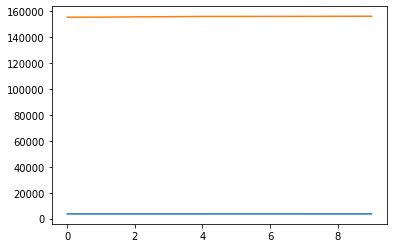

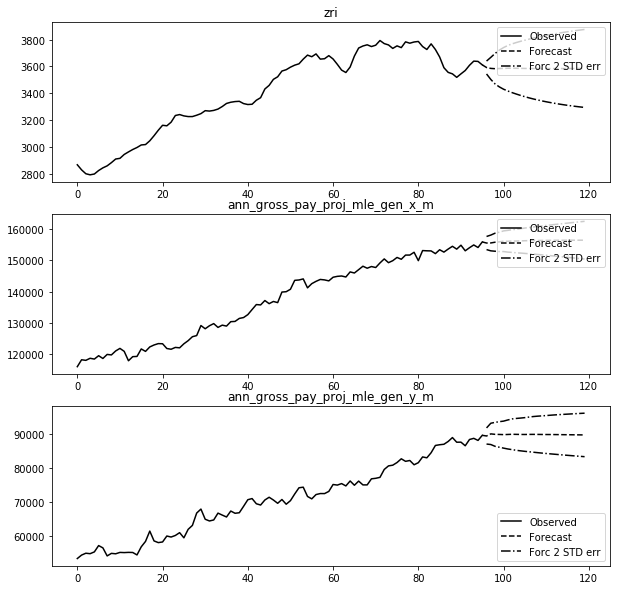

In [370]:
lag_order = ans.k_ar
f_values = ans.forecast(comb_one.values[-lag_order:,:], 10)
f_values.shape
plt.plot(np.arange(10), f_values[:,0])
plt.plot(np.arange(10), f_values[:,1])
ans.plot_forecast(24)
plt.legend(loc='lower right')

This doesn't seem to be working... Now try predict percentage difference.

In [858]:
one = zri.iloc[80,:]

selected = ['ann_gross_pay_proj_mle_gen_x_m','ann_gross_pay_proj_mle_gen_y_m']
adp_one = adp[adp.index.map(lambda idx: idx[1] ==  one.name)][selected].unstack()

In [859]:
comb_one = pd.concat([one,adp_one],axis=1)
comb_one.index = pd.to_datetime(comb_one.index)
comb_one.columns = ['zri']+selected

In [860]:
perc_diff_one = (comb_one.diff()/comb_one).iloc[1:,:]

In [861]:
train_one = perc_diff_one.iloc[:-12,:]
test_one = perc_diff_one.iloc[-12:,:]

In [862]:
model_diff = VAR(train_one, dates=train_one.index)

In [863]:
import warnings
with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            ans_diff = model_diff.fit(12, ic = 'aic')  # 2 stands for maxlags

In [864]:
# with warnings.catch_warnings():
#             warnings.filterwarnings("ignore")
#             model_diff.select_order(10)

In [865]:
lag_order = ans_diff.k_ar
print(lag_order)

0


In [866]:
if lag_order > 0:
    forcast = ans_diff.forecast(train_one.values[-lag_order:,:], 12)
else:
    forcast = ans_diff.params.to_numpy().repeat(12,axis=0)

In [867]:
zri_diff_forcast = forcast[:,0]

In [868]:
pre = one[-13]
zri_forcast = one[-12:].copy()

for i in range(zri_forcast.shape[0]):
    zri_forcast[i] = pre*(1+zri_diff_forcast[i])
    pre = zri_forcast[i]

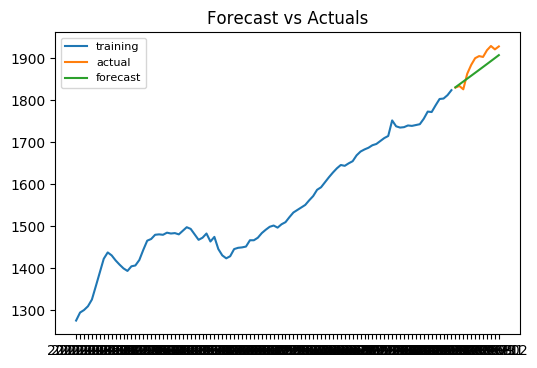

In [869]:
plt.figure(figsize=(6,4), dpi=100)
plt.plot(one[:-12], label='training')
plt.plot(one[-12:], label='actual')
plt.plot(zri_forcast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

Seems to be okay. Let's build a model for each zip code.

# Build a VAR Model on Percentage Change of ZRI for Each Zip Code

In [1270]:
selected = ['ann_gross_pay_proj_mle_gen_x_m','ann_gross_pay_proj_mle_gen_y_m','ann_gross_pay_proj_gen_x_m',
            'rate_amt_s_90perc_value','ann_bonus_m']

In [1271]:
zri_forcast = []

for i in range(zri.shape[0]):
    one = zri.iloc[i,:] # zri data for this zip code

    if np.sum(adp.index.map(lambda idx: idx[1] ==  one.name)) == 0:
        continue
    
    adp_one = adp[adp.index.map(lambda idx: idx[1] ==  one.name)][selected].unstack() # adp data for this zip code

    comb_one = pd.concat([one,adp_one],axis=1)
    comb_one.index = pd.to_datetime(comb_one.index)
    comb_one.columns = ['zri']+selected # combined zri and adp data

    perc_diff_one = (comb_one.diff()/comb_one).iloc[1:,:] # percentage change of combined data

    train_one = perc_diff_one.iloc[:-12,:] # data from 2011 to 2018
    test_one = perc_diff_one.iloc[-12:,:] # data for 2019

    model_diff = VAR(train_one, dates=train_one.index) # var model

    import warnings
    with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                ans_diff = model_diff.fit(12, ic = 'aic')  # 12 stands for maxlags

#     with warnings.catch_warnings():
#                 warnings.filterwarnings("ignore")
#                 model_diff.select_order(10)

    lag_order = ans_diff.k_ar

    if lag_order > 0:
        forcast_one = ans_diff.forecast(train_one.values[-lag_order:,:], 12)
    else:
        forcast_one = ans_diff.params.to_numpy().repeat(12,axis=0)
    
    zri_diff_forcast_one = forcast_one[:,0]
    
    pre = one[-13]
    zri_forcast_one = one[-12:].copy()

    for i in range(zri_forcast_one.shape[0]):
        zri_forcast_one[i] = pre*(1+zri_diff_forcast[i])
        pre = zri_forcast_one[i]
        
    zri_forcast.append(zri_forcast_one)


In [1272]:
zri_forcast = pd.DataFrame(zri_forcast)

In [1273]:
actual = zri.iloc[zri.index.isin(zri_forcast.index),-12:]

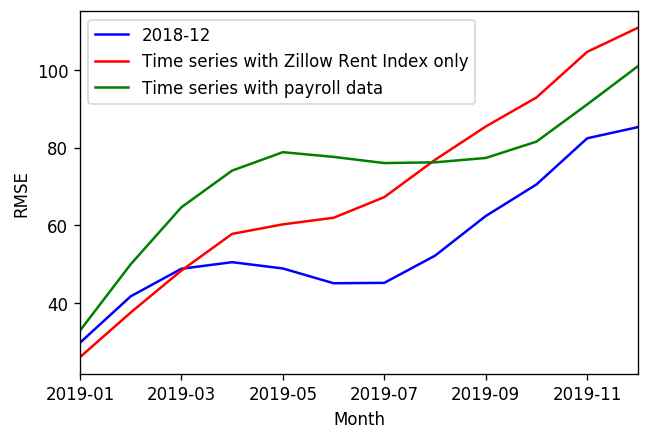

In [1274]:
rmse_toy = (np.sum((toy_model - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_toy.plot(c='b',label = '2018-12')

rmse_bm = (np.sum((predict_bm - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_bm.plot(c='r',label = 'Time series with Zillow Rent Index only')

rmse_var = (np.sum((zri_forcast - actual)**2)/actual.shape[0]).map(math.sqrt)
rmse_var.plot(c='g',label = 'Time series with payroll data')

plt.xlabel('Month')
plt.ylabel('RMSE')
plt.legend()

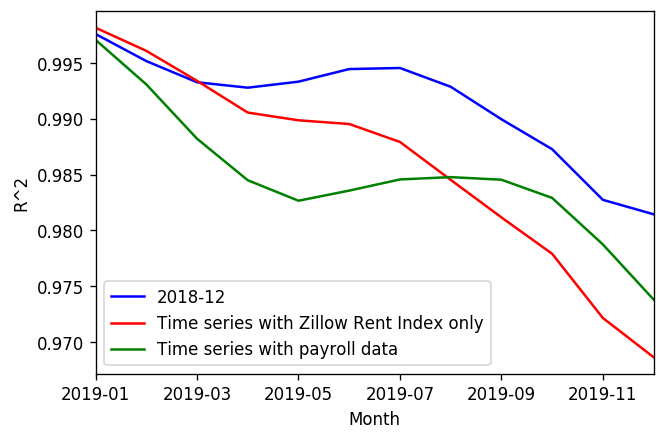

In [1275]:
R2_toy = 1-np.sum((zri_test-toy_model)**2)/np.sum((zri_test-zri_test.mean())**2)
R2_toy.plot(c='b',label = '2018-12')

R2_bm = 1-np.sum((zri_test-predict_bm)**2)/np.sum((zri_test-zri_test.mean())**2)
R2_bm.plot(c='r',label = 'Time series with Zillow Rent Index only')

R2_var = 1-np.sum((actual-zri_forcast)**2)/np.sum((actual-actual.mean())**2)
R2_var.plot(c='g',label = 'Time series with payroll data')

plt.xlabel('Month')
plt.ylabel('R^2')
plt.legend()

In [1186]:
season_std

,zip,seasonal_std,resid_std,ratio
0,10025,0.008275,0.012115,0.683008
1,10023,0.006486,0.010270,0.631516
2,11226,0.005708,0.007316,0.780244
3,10467,0.001747,0.008405,0.207803
4,10016,0.005381,0.009578,0.561876
...,...,...,...,...
133,11429,0.002946,0.009339,0.315467
134,10470,0.001455,0.015130,0.096165
135,10302,0.010389,0.017422,0.596339
136,11416,0.002108,0.004509,0.467598


Even worse!

# Use Rolling Average

In [1252]:
one = zri.iloc[0,:]

# selected = ['ann_gross_pay_proj_mle_gen_x_m','ann_gross_pay_proj_mle_gen_y_m']
adp_one = adp[adp.index.map(lambda idx: idx[1] ==  one.name)].unstack()

In [1253]:
n_window = 3
adp_one = (adp_one.rolling(n_window).mean()).iloc[n_window-1:,:]

In [1254]:
comb_one = pd.concat([one,adp_one],axis=1,join='inner')
comb_one.index = pd.to_datetime(comb_one.index)
comb_one.columns = ['zri']+adp.columns.to_list()

In [1255]:
perc_diff_one = (comb_one.diff()/comb_one).iloc[1:,:]
perc_diff_one = perc_diff_one.replace([np.inf, -np.inf], np.nan)
perc_diff_one = perc_diff_one.dropna(axis=1,how='any')

In [1256]:
train_one = perc_diff_one.iloc[:-12,:-3]
test_one = perc_diff_one.iloc[-12:,:-3]

In [1258]:
selected = ['ann_gross_pay_proj_mle_gen_x_m','ann_gross_pay_proj_mle_gen_y_m','ann_gross_pay_proj_gen_x_m',
            'rate_amt_s_90perc_value','ann_bonus_m']

In [1259]:
zri_forcast_rolling = []

for i in range(zri.shape[0]):
    one = zri.iloc[i,:] # zri data for this zip code

    if np.sum(adp.index.map(lambda idx: idx[1] ==  one.name)) == 0:
        continue
    
    adp_one = adp[adp.index.map(lambda idx: idx[1] ==  one.name)][selected].unstack() # adp data for this zip code

    n_window = 3
    adp_one = (adp_one.rolling(n_window).mean()).iloc[n_window-1:,:]

    comb_one = pd.concat([one,adp_one],axis=1,join='inner')
    comb_one.index = pd.to_datetime(comb_one.index)
    comb_one.columns = ['zri']+selected # combined zri and adp data

    perc_diff_one = (comb_one.diff()/comb_one).iloc[1:,:] # percentage change of combined data

    perc_diff_one = (comb_one.diff()/comb_one).iloc[1:,:]
    perc_diff_one = perc_diff_one.replace([np.inf, -np.inf], np.nan)
    perc_diff_one = perc_diff_one.dropna(axis=1,how='any')

    train_one = perc_diff_one.iloc[:-12,:-3] # data from 2011 to 2018
    test_one = perc_diff_one.iloc[-12:,:-3] # data for 2019

    model_diff = VAR(train_one, dates=train_one.index) # var model

    import warnings
    with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                ans_diff = model_diff.fit(12, ic = 'aic')  # 12 stands for maxlags

#     with warnings.catch_warnings():
#                 warnings.filterwarnings("ignore")
#                 model_diff.select_order(10)

    lag_order = ans_diff.k_ar

    if lag_order > 0:
        forcast_one = ans_diff.forecast(train_one.values[-lag_order:,:], 12)
    else:
        forcast_one = ans_diff.params.to_numpy().repeat(12,axis=0)
    
    zri_diff_forcast_one = forcast_one[:,0]
    
    pre = one[-13]
    zri_forcast_one = one[-12:].copy()

    for i in range(zri_forcast_one.shape[0]):
        zri_forcast_one[i] = pre*(1+zri_diff_forcast[i])
        pre = zri_forcast_one[i]
        
    zri_forcast_rolling.append(zri_forcast_one)


In [1261]:
zri_forcast_rolling = pd.DataFrame(zri_forcast_rolling)

In [1262]:
actual = zri.iloc[zri.index.isin(zri_forcast_rolling.index),-12:-3]

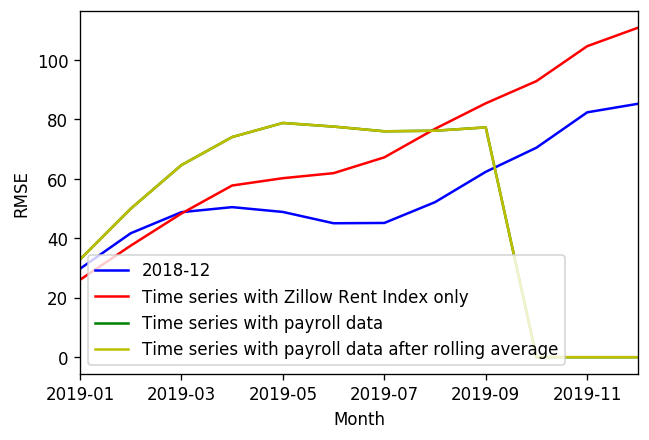

In [1265]:
rmse_toy = (np.sum((toy_model - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_toy.plot(c='b',label = '2018-12')

rmse_bm = (np.sum((predict_bm - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_bm.plot(c='r',label = 'Time series with Zillow Rent Index only')

rmse_var = (np.sum((zri_forcast - actual)**2)/actual.shape[0]).map(math.sqrt)
rmse_var.plot(c='g',label = 'Time series with payroll data')

rmse_var = (np.sum((zri_forcast_rolling - actual)**2)/actual.shape[0]).map(math.sqrt)
rmse_var.plot(c='y',label = 'Time series with payroll data after rolling average')

plt.xlabel('Month')
plt.ylabel('RMSE')
plt.legend()

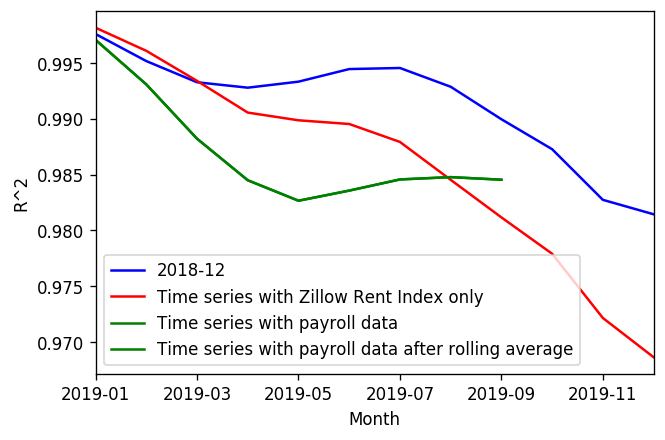

In [1267]:
R2_toy = 1-np.sum((zri_test-toy_model)**2)/np.sum((zri_test-zri_test.mean())**2)
R2_toy.plot(c='b',label = '2018-12')

R2_bm = 1-np.sum((zri_test-predict_bm)**2)/np.sum((zri_test-zri_test.mean())**2)
R2_bm.plot(c='r',label = 'Time series with Zillow Rent Index only')

R2_var = 1-np.sum((actual-zri_forcast)**2)/np.sum((actual-actual.mean())**2)
R2_var.plot(c='g',label = 'Time series with payroll data')

R2_var = 1-np.sum((actual-zri_forcast_rolling)**2)/np.sum((actual-actual.mean())**2)
R2_var.plot(c='g',label = 'Time series with payroll data after rolling average')

plt.xlabel('Month')
plt.ylabel('R^2')
plt.legend()

No difference!

# K-Means to Identify APD Features That Have Similar Time Series Shape as ZRI

In [1073]:
one = zri.iloc[0,:]

# selected = ['ann_gross_pay_proj_mle_gen_x_m','ann_gross_pay_proj_mle_gen_y_m']
adp_one = adp[adp.index.map(lambda idx: idx[1] ==  one.name)].unstack()

In [1074]:
n_window = 3
adp_one = (adp_one.rolling(n_window).mean()).iloc[n_window-1:,:]

In [1075]:
comb_one = pd.concat([one,adp_one],axis=1,join='inner')
comb_one.index = pd.to_datetime(comb_one.index)
comb_one.columns = ['zri']+adp.columns.to_list()

In [1076]:
perc_diff_one = (comb_one.diff()/comb_one).iloc[1:,:]
perc_diff_one = perc_diff_one.replace([np.inf, -np.inf], np.nan)
perc_diff_one = perc_diff_one.dropna(axis=1,how='any')

In [1077]:
train_one = perc_diff_one.iloc[:-12,:-3]
test_one = perc_diff_one.iloc[-12:,:-3]

In [1078]:
from sklearn.cluster import KMeans
from collections import defaultdict

In [1079]:
kmeans = KMeans(n_init=40)

In [1080]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

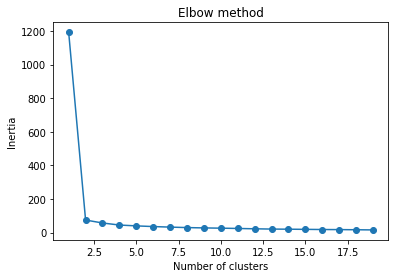

In [1085]:
plot_inertia(kmeans, train_one, range(1, 20))

No clear cluster?

# Seasonal Component

## Seasonal Decomposite

Text(0.5, 1.0, 'New York, 10470')

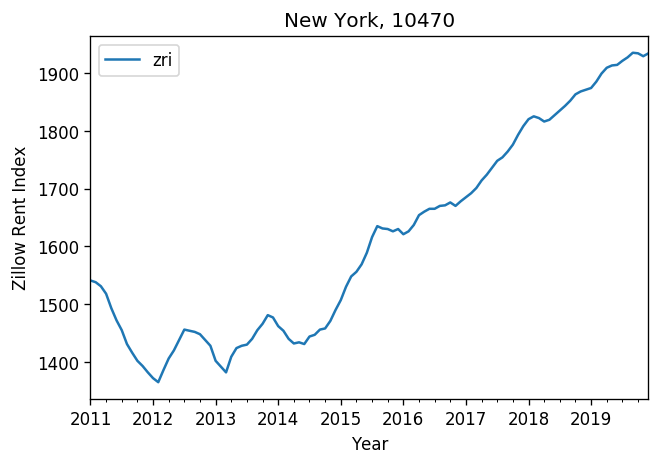

In [1242]:
zip_number = '11216'
zipcode = zri.loc[zri.index==zip_number,:].T
zipcode.index = pd.to_datetime(zipcode.index)
zipcode.columns = ['zri']
zipcode.plot()
plt.xlabel('Year')
plt.ylabel('Zillow Rent Index')
plt.title('New York, 10006')

Text(0.5, 1.0, 'New York, 10470')

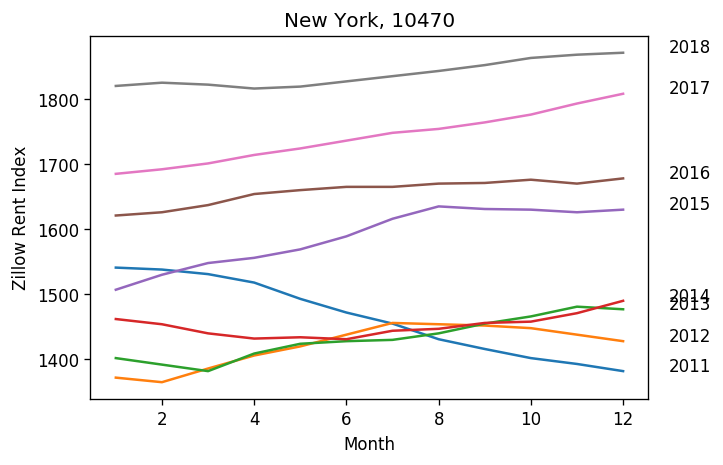

In [1243]:
zipcode['year'] = zipcode.index.year
zipcode['month'] = zipcode.index.month
for y in range(2011,2019):
    plt.plot('month','zri',data = zipcode.loc[zipcode['year'] == y,:])
    plt.text(zipcode.loc[zipcode.year==y, :].shape[0]+1, zipcode.loc[zipcode.year==y, 'zri'][-1:].values[0], y)
plt.xlabel('Month')
plt.ylabel('Zillow Rent Index')
plt.title('New York, '+zip_number)

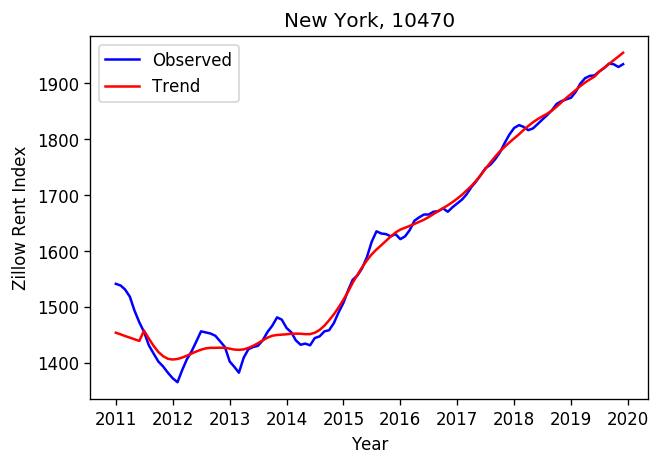

In [1244]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zipcode['zri'], model='multiplicative', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plt.plot(zipcode['zri'],color='b',label='Observed')
plt.plot(decomp.trend,color='r',label='Trend')
plt.xlabel('Year')
plt.ylabel('Zillow Rent Index')
plt.title('New York, '+zip_number)
plt.legend()

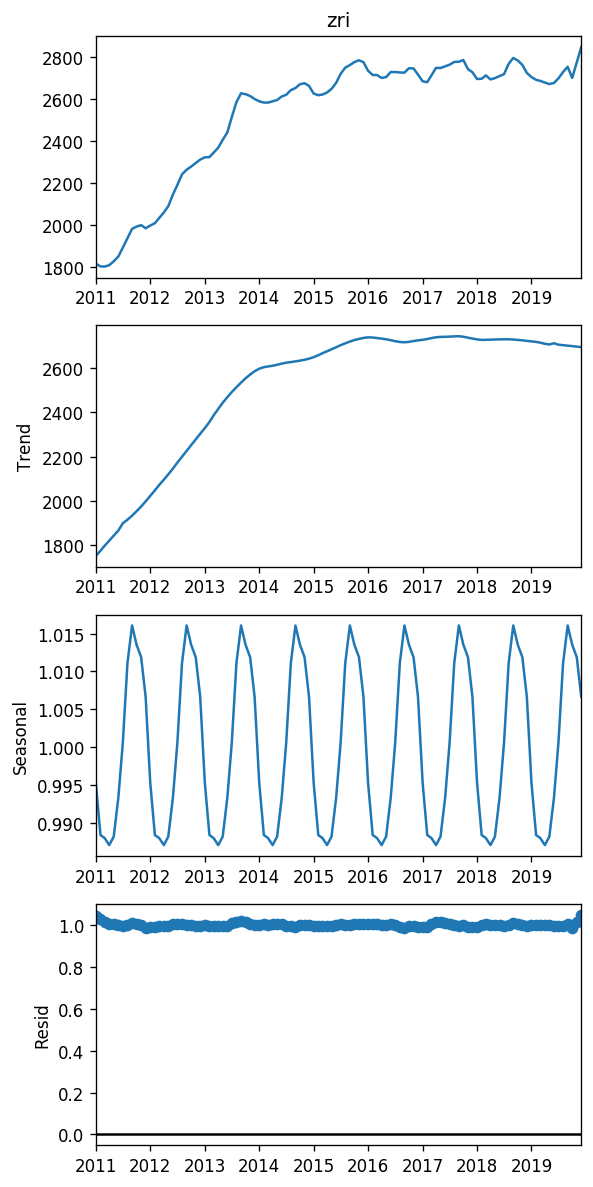

In [1237]:
plt.rcParams.update({'figure.figsize':(5,10), 'figure.dpi':120})
decomp.plot();

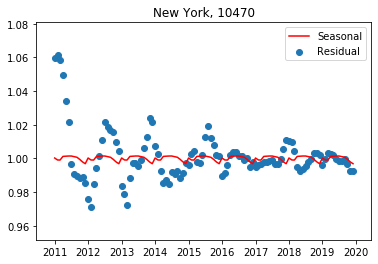

In [1226]:
plt.scatter(decomp.resid.index,decomp.resid,label='Residual')
plt.plot(decomp.seasonal,color='r',label='Seasonal')
plt.title('New York, '+zip_number)
plt.legend()

In [1212]:
decomp.seasonal.std()

0.010865773229918961

In [1213]:
decomp.resid.std()

0.009370965824422041

In [1159]:
seasonal_std = []
resid_std = []

for i in range(zri.shape[0]):

    zipcode = zri.iloc[i,:].T
    zipcode.index = pd.to_datetime(zipcode.index)
    
    decomp = seasonal_decompose(zipcode, model='multiplicative', extrapolate_trend='freq')
    seasonal_std.append(decomp.seasonal.std())
    resid_std.append(decomp.resid.std())


In [1185]:
season_std = pd.DataFrame({'zip':zri.index,'seasonal_std':seasonal_std,'resid_std':resid_std})
season_std['ratio'] = season_std['seasonal_std']/season_std['resid_std']

In [1214]:
season_index = (season_std.sort_values('ratio',ascending=False)[:10]).zip

In [1216]:
season_std.sort_values('ratio',ascending=False)

,zip,seasonal_std,resid_std,ratio
32,11238,0.010866,0.009371,1.159515
56,11216,0.009801,0.008766,1.118078
24,11207,0.005714,0.005727,0.997813
83,11249,0.013954,0.014449,0.965721
12,11206,0.010204,0.010928,0.933746
...,...,...,...,...
72,10461,0.000928,0.006431,0.144256
59,10466,0.001486,0.011958,0.124308
126,11417,0.000847,0.007249,0.116781
134,10470,0.001455,0.015130,0.096165


In [1215]:
region[region['zip'].isin(season_index)]

,zip,RegionID,City,State,Metro,CountyName,SizeRank
12,11206,62017,New York,NY,New York-Newark-Jersey City,Kings County,39
21,11221,62032,New York,NY,New York-Newark-Jersey City,Kings County,60
24,11207,62018,New York,NY,New York-Newark-Jersey City,Kings County,78
27,11211,62022,New York,NY,New York-Newark-Jersey City,Kings County,96
32,11238,62048,New York,NY,New York-Newark-Jersey City,Kings County,109
38,11233,62043,New York,NY,New York-Newark-Jersey City,Kings County,155
46,11208,62019,New York,NY,New York-Newark-Jersey City,Kings County,246
50,11213,62024,New York,NY,New York-Newark-Jersey City,Kings County,268
56,11216,62027,New York,NY,New York-Newark-Jersey City,Kings County,321
83,11249,62058,New York,NY,New York-Newark-Jersey City,Kings County,804


In [1180]:
import folium

In [1187]:
ny_geo_all = f'../data/nyu-2451-34509-geojson.json'

seasonal_index = folium.Map(location=[40.730610, -73.935242],zoom_start=11)

folium.Choropleth(
    geo_data=ny_geo_all,
    name='choropleth',
    data=season_std,
    columns=['zip', 'ratio'],
    key_on='feature.properties.zcta', # Use 'feature', not 'features'. this seems to be a bug
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Seasonal Index'
).add_to(seasonal_index)

folium.LayerControl().add_to(seasonal_index)

seasonal_index

In [1227]:
seasonal_index.save('../fig/seasonal_index.html')

## SARIMA Model

In [1106]:
stat_sar = pd.DataFrame(np.zeros(shape=(zri_train.shape[0],4)),index=zri_train.index,
                        columns=['ar','p(ar)','s','p(s)'])
predict_sar = pd.DataFrame(np.zeros(shape=(zri_train.shape[0],12)),index=zri_train.index,
                           columns=[str(i) for i in range(1,13)])

In [1107]:
# About 40 minutes
import warnings
warnings.filterwarnings('ignore')
nzip = zri_train.shape[0]
for i in range(nzip):
    one = zri_train.iloc[i,:]
    mod = sm.tsa.statespace.SARIMAX(one, order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
    res = mod.fit(disp=False)
    stat_sar.iloc[i,:] = [res.arparams[0],res.pvalues[0],res.seasonalarparams[0],res.pvalues[1]]
    predict_sar.iloc[i,:] = res.predict('2019-01','2019-12').to_list()
#     print(i,' out of ', nzip)
#     print(stat.iloc[i,:])
#     print(predict.iloc[i,:])

In [1108]:
pe = pd.DataFrame(np.zeros(shape=(zri_train.shape[0],1)),index=zri_train.index,columns=['Percentage Error'])
for i in range(nzip):
    testone = zri_test.iloc[i,:].to_numpy()
    predictone = predict_sar.iloc[i,:].to_numpy()
    pe.iloc[i,:] = np.sum(abs(predictone-testone)/testone)/12.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f135bd0>]],
      dtype=object)

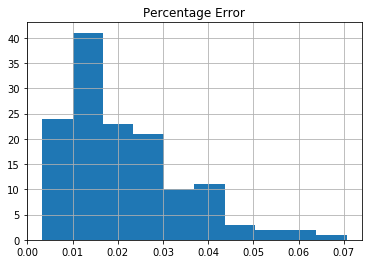

In [1110]:
pe.hist(bins=10)

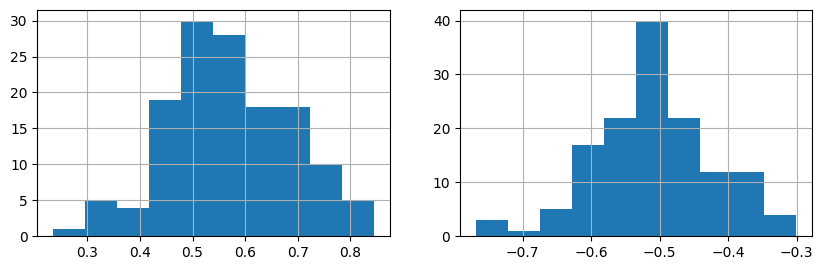

In [1111]:
fig, axes = plt.subplots(1, 2, figsize=(10,3), dpi=100)
stat_sar['ar'].hist(bins=10,ax=axes[0])
stat_sar['s'].hist(bins=10,ax=axes[1])

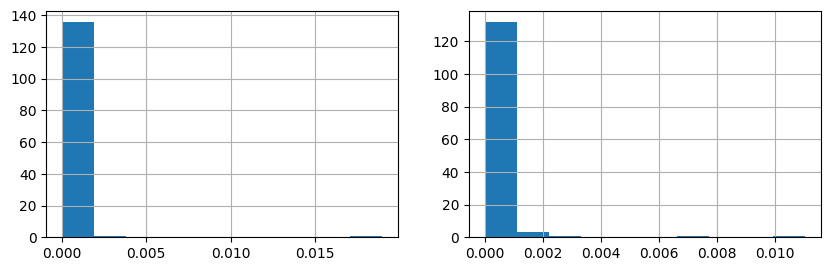

In [1120]:
fig, axes = plt.subplots(1, 2, figsize=(10,3), dpi=100)
stat_sar['p(ar)'].hist(bins=10,ax=axes[0])
stat_sar['p(s)'].hist(bins=10,ax=axes[1])

In [1124]:
stat_sar[stat_sar['s'] < -0.7]

,ar,p(ar),s,p(s)
zip,,,,
11226,0.801347,3.502706e-28,-0.755526,2.080242e-17
11201,0.546605,4.118901e-08,-0.768148,2.157797e-17
10453,0.541523,4.092585e-13,-0.743941,8.024817e-66


Text(0.5, 1.0, 'Forcast - Actual')

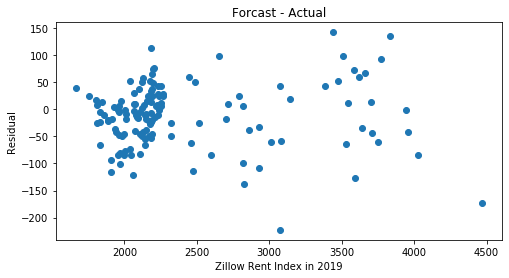

In [1112]:
plt.figure(figsize=(8,4))
plt.scatter(zri_test.mean(axis=1),predict_sar.mean(axis=1)-zri_test.mean(axis=1))
plt.xlabel('Zillow Rent Index in 2019')
plt.ylabel('Residual')
plt.title('Forcast - Actual')

Text(0.5, 1.0, '(Forcast - Actual) / Actual')

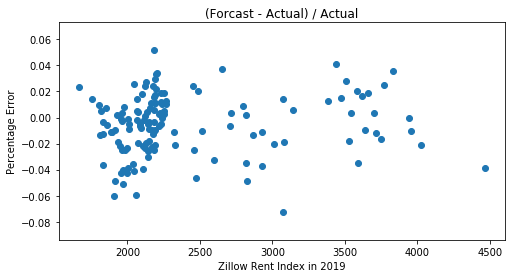

In [1113]:
plt.figure(figsize=(8,4))
plt.scatter(zri_test.mean(axis=1),(predict_sar.mean(axis=1)-zri_test.mean(axis=1))/zri_test.mean(axis=1))
plt.xlabel('Zillow Rent Index in 2019')
plt.ylabel('Percentage Error')
plt.title('(Forcast - Actual) / Actual')

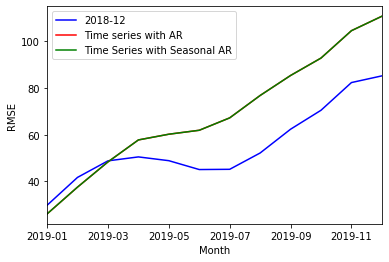

In [1116]:
predict_sar.columns = zri_test.columns

toy_model = pd.concat([zri_train.iloc[:,-1]]*12,axis=1)
toy_model.columns = zri_test.columns

rmse_toy = (np.sum((toy_model - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_toy.plot(c='b',label = '2018-12')

rmse_bm = (np.sum((predict_bm - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_bm.plot(c='r',label = 'Time series with AR')

rmse_bm = (np.sum((predict_sar - zri_test)**2)/zri_test.shape[0]).map(math.sqrt)
rmse_bm.plot(c='g',label = 'Time Series with Seasonal AR')

plt.xlabel('Month')
plt.ylabel('RMSE')
plt.legend()